[View in Colaboratory](https://colab.research.google.com/github/sthalles/tensorflow-tutorials/blob/master/Day_1_Pre_Made_Estimators_Solutions.ipynb)

# Pre-Made Estimators

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

The Estimator is a high-level Tensorflow API. 
- It is built on top of the TensorFlow core API.

It follows a **train-evaluate-predict** loop.

It is made to handle the boring steps of training an ML model like:

- Creating the computational graph
- Initializing Variables
- Training, testing, and making predictions
- Visualizing training specific variables (learning rate, trainable variables and performance measures)
- Saving the model


![alt text](https://www.tensorflow.org/images/tensorflow_programming_environment.png)

To write a TensorFlow program based on pre-made Estimators, you must perform the following tasks:

1.  Create one or more **input functions**.
2.  Define the model's **feature columns**.
3. Instantiate an Estimator, specifying the feature columns and various hyperparameters.
4. Train and Evaluate

# Loading Data

In [2]:
"""DO NOT NEED CHANGES"""
def maybe_download():
    train_path = tf.keras.utils.get_file(TRAIN_URL.split('/')[-1], TRAIN_URL)
    test_path = tf.keras.utils.get_file(TEST_URL.split('/')[-1], TEST_URL)

    return train_path, test_path

In [3]:
"""DO NOT NEED CHANGES"""
TRAIN_URL = "http://download.tensorflow.org/data/iris_training.csv"
TEST_URL = "http://download.tensorflow.org/data/iris_test.csv"

CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth',
                    'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']


def load_dataset():
  train_path, test_path = maybe_download()
  train_data = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
  test_data = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)
  
  train_input = train_data[CSV_COLUMN_NAMES[0:-1]]
  train_labels = train_data[CSV_COLUMN_NAMES[-1]]
  
  test_input = test_data[CSV_COLUMN_NAMES[0:-1]]
  test_labels = test_data[CSV_COLUMN_NAMES[-1]]
  
  return (train_input, train_labels), (test_input, test_labels)

![alt text](https://www.tensorflow.org/images/iris_three_species.jpg)

In [4]:
(X_train, y_train), (X_test, y_test) = load_dataset()

In [5]:
print("Visualize the Dataset shapes")
print("Train input:", X_train.shape)
print("Train labels:", y_train.shape)
print("Test input:", X_test.shape)
print("Test labels:", y_test.shape)

Visualize the Dataset shapes
Train input: (120, 4)
Train labels: (120,)
Test input: (30, 4)
Test labels: (30,)


The Iris data set contains 4 features and 1 label. 

The 4 **features** identify the following botanical characteristics of individual Iris flowers:

- sepal length
- sepal width
- petal length
- petal width

![alt text](http://s5047.pcdn.co/wp-content/uploads/2015/04/iris_petal_sepal.png)

Our model will represent these features as float32 numerical data.

The **label** identifies the Iris species, which must be one of the following:

- Iris setosa (0)
- Iris versicolor (1)
- Iris virginica (2)

Our model will represent the label as int32 categorical data.

In [6]:
X_train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3


In [7]:
y_train.head()

0    2
1    1
2    2
3    0
4    0
Name: Species, dtype: int64

##  Exercise: Creating Validation (Dev set)

The Iris dataset is divided into Training and Testing sets.

This time, let's **NOT** use the Test set for development. 

The idea is to have a different set for which we can perform **hyperparameter tuning** during training.

That is the Dev or **Validation set**.

- Separate the training set into 2 sets: **training** and **validation**.

### Tip
- *The size of the validation set may vary. 10 - 20% are good choices for this dataset.*
- Use sklearn [train_test_split()](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).


In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [9]:
print("Training/validation shapes")
print("Train input:", X_train.shape)
print("Train labels:", y_train.shape)
print("Test input:", X_val.shape)
print("Test labels:", y_val.shape)

Training/validation shapes
Train input: (102, 4)
Train labels: (102,)
Test input: (18, 4)
Test labels: (18,)


# Creating Input funcions

**Input functions are responsible for feeding data to ML Models created with the TF Estimators API.**

The Estimator expects an *input_function()* to return a [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) or a tuple of *(features, labels)*.

Let's use the **tf.data.Dataset** as our input streaming.
-  [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) is the recommended Tensorflow input pipeline.

Hint: [tf.data.Dataset template](https://www.tensorflow.org/get_started/datasets_quickstart)

In [10]:
def train_input_fn(features, labels, batch_size):
  """
  Provides input data for training
  Return: A 'tf.data.Dataset' object: tuple (features, labels). 
          Or tuple (features, labels)
  """
  
  # Create the dataset object and return it
  # Make sure you shuffle and define the batch size as given by the 'batch_size' parameter
  dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
  dataset = dataset.shuffle(buffer_size=100)
  dataset = dataset.repeat()
  dataset = dataset.batch(batch_size)
  return dataset # return the dataset object

In [11]:
def eval_input_fn(features, labels, batch_size):
  
  features = dict(features)
  if labels is None:
    inputs = features
  else:
    inputs = (dict(features), labels)
  
  # Create the tf.data.Dataset() object and return it
  # Set the number of epochs to 0
  dataset = tf.data.Dataset.from_tensor_slices(inputs)
  dataset = dataset.repeat(1)
  dataset = dataset.batch(batch_size)
  return dataset

# Defining the Feature Columns

Now, we have to convert our data into **Tensors** so that our Model can use it.

Feature Columns provides a representation of how our model should interpret the data it will receive.
- Is this column Numerical, Categorical or what?

![alt text](https://www.tensorflow.org/images/feature_columns/some_constructors.jpg)

**Feature Columns** define the **type of features** we are going to feed into our Models.

The choice of Feature Column depends on the Variable and Model type.

Since the 4 feature columns of the Iris dataset are represented as continuos values, we need to especify it when creating the feature columns.

To do that, we use the: [tf.feature_column.numeric_column()](https://www.tensorflow.org/api_docs/python/tf/feature_column/numeric_column) constructor.

  - **tf.feature_column.numeric_column()** Represents real valued or numerical features.
  
Info++: [Feature Engineering](https://www.tensorflow.org/get_started/feature_columns)
  
 


In [12]:
# feature columns define how to use the feature data
my_feature_columns = []
for feature_column in X_train.keys():
  # use tf.feature_column.numeric_column() to create a feature column and add it to the 'my_feature_columns' list
  my_feature_columns.append(tf.feature_column.numeric_column(key=feature_column))

# Hyperparameters

1. Tune the hyperparameters bellow.

In [13]:
learning_rate = 0.1
number_of_classes = 3 # number of classes from the Iris dataset
batch_size = 16 # number of examples to feed to the network per step
max_step = 2000 # maximum number of training steps
regularization = 0.001 # regularization strength


# Building the Estimator

An Estimator encapsulates all the necessary parts of a model. 

Some of the available Estimators include:

1. **BoostedTrees** Classifier/Regressor
2. **DNN Classifier**/Regressor
3. **DNNLinearCombined** Classifier/Regressor
4. **Linear** Classifier/Regressor

Checkout: [tf.estimator](https://www.tensorflow.org/api_docs/python/tf/estimator)

## Exercise

1. Use the [tf.estimator.LinearClassifier](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier) to classify the Iris Dataset.

Things to keep in mind.
  - Linear models are very simple, for this case, pay special attention to the **number of classes** and the **learning rate** tunning.
  - Play with different configurations of **batch size**, it can have dramatic effects on how quick the model converges.

In [14]:
classifier = tf.estimator.LinearClassifier(    
    feature_columns=my_feature_columns, # pass the feature columns to the Linear Classifier
    n_classes=number_of_classes, # Set the number of classes defined above
    optimizer=tf.train.FtrlOptimizer( # Configure the loss function
      learning_rate=learning_rate, # setup the learning rate
      l1_regularization_strength=regularization # set the regularization strength 
    ))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp6_nhm63b', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3763ec1518>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Tip

You do NOT need to define nor control the TensorFlow Session. 
*Estimators take care of that for you.*

## Exercise

Use the *classifier.train()* method to train the built classifier.
- Pass the  *train_input_fn()* as a lambda so you can control its input parameters.
- Set the *steps* parameter to the maximum number of steps you defined to train your model.

In [15]:
classifier.train(input_fn=lambda: train_input_fn(X_train, y_train, batch_size=batch_size), 
                 steps=max_step #  Number of steps for which to train model.
                )

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp6_nhm63b/model.ckpt.
INFO:tensorflow:loss = 17.577797, step = 0
INFO:tensorflow:global_step/sec: 188.16
INFO:tensorflow:loss = 5.9322495, step = 100 (0.538 sec)
INFO:tensorflow:global_step/sec: 209.333
INFO:tensorflow:loss = 4.490634, step = 200 (0.478 sec)
INFO:tensorflow:global_step/sec: 202.206
INFO:tensorflow:loss = 7.860841, step = 300 (0.490 sec)
INFO:tensorflow:global_step/sec: 225.696
INFO:tensorflow:loss = 3.8077915, step = 400 (0.446 sec)
INFO:tensorflow:global_step/sec: 194.049
INFO:tensorflow:loss = 3.7085443, step = 500 (0.513 sec)
INFO:tensorflow:global_step/sec: 202.352
INFO:tensorflow:loss = 3.2970886, step = 600 (0.493 sec)
INFO:tensorflow:global_step/sec: 198.706
INFO:tensorflow:los

## Exercise - Validation

Use the *eval_input_fn()* method to measure the performance of your model.

- Use the **Validation set** to evaluate how good your model is becoming. 
- Here you are allowed to use this dataset to **change the model's hyperparameters**.





In [68]:
eval_results = classifier.evaluate(input_fn=lambda: eval_input_fn(X_val, y_val, batch_size=16))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-25-15:58:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp6_nhm63b/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-25-15:58:48
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9444444, average_loss = 0.1985368, global_step = 2000, loss = 1.7868311
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp6_nhm63b/model.ckpt-2000


## Exercise -Test

Now, we want to use our **Testing set** to see how good our model really is.
- Use the Unseen Test set now.
- Use the same *eval_input_fn()* method you used for validation.

In [69]:
predictions = classifier.predict(lambda: eval_input_fn(X_test, labels=None, batch_size=16))

In [70]:
# Visualize the predictions and confidence for each of the Test set records
SPECIES = ['Setosa', 'Versicolor', 'Virginica']
template = ('\nPrediction is "{}" ({:.1f}%), expected "{}"')
prediction_values = []
for pred_dict, expec in zip(predictions, y_test):
  class_id = pred_dict['class_ids'][0]
  prediction_values.append(class_id)
  probability = pred_dict['probabilities'][class_id]

  print(template.format(SPECIES[class_id],
                    100 * probability, SPECIES[expec]))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp6_nhm63b/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

Prediction is "Versicolor" (74.7%), expected "Versicolor"

Prediction is "Virginica" (79.4%), expected "Virginica"

Prediction is "Setosa" (96.2%), expected "Setosa"

Prediction is "Versicolor" (72.5%), expected "Versicolor"

Prediction is "Versicolor" (73.3%), expected "Versicolor"

Prediction is "Versicolor" (84.5%), expected "Versicolor"

Prediction is "Setosa" (99.8%), expected "Setosa"

Prediction is "Versicolor" (51.4%), expected "Virginica"

Prediction is "Versicolor" (82.1%), expected "Versicolor"

Prediction is "Virginica" (86.2%), expected "Virginica"

Prediction is "Virginica" (87.5%), expected "Virginica"

Prediction is "Setosa" (98.9%), expected "Setosa"

Prediction is "Virginica" (87.0%), expected "Virginica

In [74]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<generator object Estimator.predict at 0x7f3747599ca8>
Confusion matrix, without normalization
[[ 8  0  0]
 [ 0 13  1]
 [ 0  1  7]]


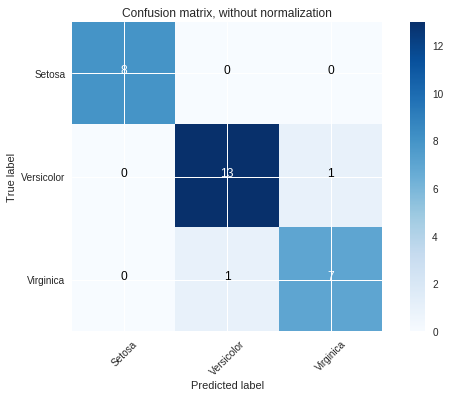

In [75]:
from sklearn.metrics import confusion_matrix
print(predictions)
cnf_matrix = confusion_matrix(y_test, prediction_values)
plot_confusion_matrix(cnf_matrix, classes=SPECIES,
                      title='Confusion matrix, without normalization')

# Deep Neural Networks

### Definition:

"*...a computing system made up of a number of simple, highly interconnected processing elements, which process information by their dynamic state response to external inputs.*"

- Function approximator
- Very powerful for non-linear relationships
- Represents a function as the composition of many functions.

## Exercise

1. Change the Linear Model Estimator to a Deep Neural Network.
- Head over to the Tensorflow documentation for [tf.estimator.DNNClassifier](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier) and check it out.

Think about:

- How many layers you need
- The number of units in each layer
- The activation function used by default
- The Gradient Descent Optimizer. 

![alt text](https://www.tensorflow.org/images/custom_estimators/full_network.png)

## Architecturing your network

![LeNet-5](http://cs231n.github.io/assets/nn1/layer_sizes.jpeg)

Neural Nets with more hidden layers are able to represent more complex functions. 

- With more power comes complicated decision boundaries.

Take care with **Overfitting**!

- It occurs when a model with **high capacity** fits the noise in the data instead of the (assumed) underlying relationship.


# Regularization

Effects of Regularization. The figure below shows the decision boundaries of the same DNN (20 hidden units), with different regularization penalties. 

Note that more regularization smooths the decision boundary.

- It fights **Overfitting**.

![alt text](http://cs231n.github.io/assets/nn1/reg_strengths.jpeg)